<a href="https://colab.research.google.com/github/Noisy-H/5243_project_HW/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from os.path import join

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn import preprocessing

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Processing

In [42]:
# Load the data
directory_path = "/content/drive/MyDrive/columbia_HW/5243/Part 3"
file_name = "tweets.csv"
pth = join(directory_path, file_name)
df = pd.read_csv(pth)
# df = pd.read_csv(file_name)

In [43]:
def text_clean(text):
    text = re.sub(r'https?://\S+', '', text) #removing links
    text = re.sub(r'\n', ' ', text) #removing line breaks
    text = re.sub(r'\s+', ' ', text).strip() #removing extra spaces
    return text

def hash_tags(text):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", text)]) or 'no'

def hash_tags_count(text):
    return len(re.findall(r"#\w+", text))

def mentions(text):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", text)]) or 'no'

def text_length(text):
    return len(text)

def tweet_process(df):

    df['text_length'] = df['text'].apply(lambda x: text_length(x))
    df['clean_text'] = df['text'].apply(lambda x: text_clean(x))
    df['hashtags'] = df['text'].apply(lambda x: hash_tags(x))
    df['hashtags_count'] = df['text'].apply(lambda x: hash_tags_count(x))
    df['mentions'] = df['text'].apply(lambda x: mentions(x))
    return df

# df_cln = tweet_process(df)
# df_cln.to_csv('tweets_cleaned.csv', index=False)

In [44]:
def get_sequence_vector(words, model, vector_size=100):
    vectors = [model.wv[word] for word in words if word in model.wv]

    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

In [48]:
from sklearn.model_selection import train_test_split

def Prepare_Data(df):
    df['link_in_text'] = df['text'].apply(lambda x: 1 if ("https" in x or 'http' in x) else 0)
    df['keyword_text'] = df['keyword'] + ': ' + df['clean_text']
    X_features = df[['text_length', 'hashtags_count', 'link_in_text']]
    X_text = df['keyword_text']
    X_text.fillna('', inplace=True)

    w2v_corpus = df['keyword_text'].apply(lambda x: x.split())
    w2v_model = Word2Vec(sentences=w2v_corpus, vector_size=100)
    w2v_vectors = w2v_corpus.apply(lambda x: get_sequence_vector(x, w2v_model, vector_size=100))
    w2v_vectors = np.array(w2v_vectors.values.tolist())
    X_text_w2v = w2v_vectors

    y = df['target']

    # 分割数据集，同时保留索引
    train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)
    X_train_text, X_test_text = X_text_w2v[train_idx], X_text_w2v[test_idx]
    X_train_features, X_test_features = X_features.iloc[train_idx], X_features.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 返回原始文本信息
    X_test_original = df.loc[test_idx, 'keyword_text']

    X_train = pd.concat([pd.DataFrame(X_train_text), X_train_features.reset_index(drop=True)], axis=1)
    X_test = pd.concat([pd.DataFrame(X_test_text), X_test_features.reset_index(drop=True)], axis=1)

    X_train.columns = X_train.columns.astype(str)
    X_test.columns = X_test.columns.astype(str)

    return X_train, X_test, y_train, y_test, X_test_original


In [46]:
df = pd.read_csv(directory_path+'/tweets_cleaned.csv')
# df = df.head(50)

In [49]:
X_train, X_test, y_train, y_test, X_test_original = Prepare_Data(df)

In [9]:
X_train.shape

(9096, 103)

### Logistic Regression

In [10]:
# 训练 Logistic Regression
clf_logit = LogisticRegression(max_iter=1000, class_weight='balanced')
clf_logit.fit(X_train, y_train)

# 评估 Logistic Regression
y_pred_logit = clf_logit.predict(X_test)
accuracy_logit = accuracy_score(y_test, y_pred_logit)
print("Accuracy on testing data (Logistic Regression):", accuracy_logit)

f1_score_logit = f1_score(y_test, y_pred_logit)
print("F1 score on testing data (Logistic Regression):", f1_score_logit)

Accuracy on testing data (Logistic Regression): 0.6741424802110818
F1 score on testing data (Logistic Regression): 0.4449438202247191


### Decision Tree

In [11]:
# clf = DecisionTreeClassifier(class_weight='balanced')

# X_train.columns = X_train.columns.astype(str)
# X_test.columns = X_test.columns.astype(str)


# param_grid = {
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'criterion': ['gini', 'entropy']
# }

# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1')
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_

# best_clf = DecisionTreeClassifier(**best_params, class_weight='balanced')
# best_clf.fit(X_train, y_train)

# y_pred_tree = best_clf.predict(X_test)

# accuracy_tree = accuracy_score(y_test, y_pred_tree)
# f1_score_tree = f1_score(y_test, y_pred_tree)
# print("Accuracy:", accuracy_tree)
# print("F1 score on testing data:", f1_score_tree)

### Random Forest

In [12]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10]
# }

# clf_RF = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced')

# grid_search = GridSearchCV(estimator=clf_RF, param_grid=param_grid, cv=5, scoring='f1')
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# print("Best parameters for Random Forest:", best_params)

# best_clf_RF = RandomForestClassifier(random_state=42, **best_params, class_weight='balanced')
# best_clf_RF.fit(X_train, y_train)

# y_pred_RF = best_clf_RF.predict(X_test)

# accuracy_RF = accuracy_score(y_test, y_pred_RF)
# print("Accuracy on testing data (Random Forest):", accuracy_RF)
# f1_score_RF = f1_score(y_test, y_pred_RF)
# print("F1 score on testing data (Random Forest):", f1_score_RF)

### XGBoost

In [50]:
import torch

X_train_gpu = torch.tensor(X_train.values).to('cuda')
X_test_gpu = torch.tensor(X_test.values).to('cuda')

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

scale_pos_weight = imbalance_ratio

clf_xgb_gpu = xgb.XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight, tree_method='hist', device = "cuda")


params = {
    'max_depth': [ 5],
    'learning_rate': [0.01],
    'n_estimators': [200]
}

grid_search = GridSearchCV(estimator=clf_xgb_gpu, param_grid=params, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

best_params_xgb = grid_search.best_params_
print("Best parameters for XGBoost:", best_params_xgb)

best_clf_xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=42, **best_params_xgb)
best_clf_xgb.fit(X_train, y_train)

y_pred_xgb = best_clf_xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy on testing data (XGBoost):", accuracy_xgb)
f1_score_xgb = f1_score(y_test, y_pred_xgb)
print("F1 score on testing data (XGBoost):", f1_score_xgb)

Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Accuracy on testing data (XGBoost): 0.8412489006156553
F1 score on testing data (XGBoost): 0.2525879917184265


# 2. SVM

### Soft Margin SVM with linear kernel

In [14]:
# from sklearn.metrics import f1_score
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV

# # 定义 C 值的候选范围
# param_grid = {'C': [0.1, 1, 10, 100, 1000]}

# # 创建 SVM 模型
# svm_linear_model = SVC(kernel='linear')

# # 使用 GridSearchCV 寻找最佳 C 值
# grid_search = GridSearchCV(svm_linear_model, param_grid, scoring='f1', cv=5)
# grid_search.fit(X_train, y_train)

# # 获取最佳 C 值
# best_C = grid_search.best_params_['C']
# print("Best C value:", best_C)

# # 使用最佳 C 值重新训练模型
# svm_linear_model = SVC(kernel='linear', C=best_C)
# svm_linear_model.fit(X_train, y_train)

# # 模型预测
# y_pred = svm_linear_model.predict(X_test)

# # 计算 F1 分数
# f1 = f1_score(y_test, y_pred)

# # 输出结果
# print("Final F1 Score with best C={}: {:.5f}".format(best_C, f1))

### SVM with RBF kernel

In [15]:
# from sklearn.svm import SVC
# from sklearn.metrics import f1_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import StandardScaler

# # 数据标准化
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # 定义参数网格
# param_grid = {'C': [10000], 'gamma': [0.001]}

# # 初始化 SVM 模型，添加 probability=True
# svm_rbf_model = SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True)

# # 使用 GridSearchCV 进行超参数搜索
# grid_search = GridSearchCV(svm_rbf_model, param_grid, cv=5, scoring='f1')
# grid_search.fit(X_train_scaled, y_train)

# # 获取最佳模型
# best_svm_rbf_model = grid_search.best_estimator_

# # 在测试集上进行预测
# y_pred_svm_rbf = best_svm_rbf_model.predict(X_test_scaled)

# # 计算 F1 分数
# f1_svm_rbf = f1_score(y_test, y_pred_svm_rbf)
# print("Best parameters:", grid_search.best_params_)
# print("F1 Score (SVM with RBF kernel):", f1_svm_rbf)


In [16]:
# from imblearn.over_sampling import SMOTE
# from sklearn.svm import SVC
# from sklearn.metrics import f1_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# param_grid = {'C': [100, 1000, 5000], 'gamma': [0.001, 0.01, 0.1]}
# svm_rbf_model = SVC(kernel='rbf', random_state=42)
# grid_search = GridSearchCV(svm_rbf_model, param_grid, cv=5, scoring='f1')
# grid_search.fit(X_train_resampled, y_train_resampled)

# best_svm_rbf_model = grid_search.best_estimator_

# y_pred_svm_rbf = best_svm_rbf_model.predict(X_test_scaled)

# f1_svm_rbf = f1_score(y_test, y_pred_svm_rbf)
# print("Best parameters:", grid_search.best_params_)
# print("F1 Score (SVM with RBF kernel and SMOTE):", f1_svm_rbf)

### SVM with sigmoid kernel

In [17]:
# from sklearn.svm import SVC
# from sklearn.metrics import f1_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# param_grid = {'C': [10, 50, 100, 1000], 'gamma': [0.00001, 0.0001, 0.001]}
# svm_sigmoid_model = SVC(kernel='sigmoid', random_state=42, class_weight='balanced')
# grid_search = GridSearchCV(svm_sigmoid_model, param_grid, cv=5, scoring='f1')
# grid_search.fit(X_train_scaled, y_train)

# best_svm_sigmoid_model = grid_search.best_estimator_

# y_pred_svm_sigmoid = best_svm_sigmoid_model.predict(X_test_scaled)

# f1_svm_sigmoid = f1_score(y_test, y_pred_svm_sigmoid)

# print("Best parameters:", grid_search.best_params_)
# print("F1 Score (SVM with sigmoid kernel):", f1_svm_sigmoid)

In [18]:
# from sklearn.ensemble import BaggingClassifier

# svm_sigmoid_estimator = SVC(kernel='sigmoid', **grid_search.best_params_, random_state=42, class_weight='balanced')

# bagging_svm_sigmoid = BaggingClassifier(base_estimator=svm_sigmoid_estimator, n_estimators=10, random_state=42)
# bagging_svm_sigmoid.fit(X_train_scaled, y_train)

# y_pred_bagging_svm_sigmoid = bagging_svm_sigmoid.predict(X_test_scaled)

# f1_bagging_svm_sigmoid = f1_score(y_test, y_pred_bagging_svm_sigmoid)
# print("F1 Score (Bagging SVM with sigmoid kernel):", f1_bagging_svm_sigmoid)

# Deep Learning Models

In [19]:
import torch
from torch import nn
from transformers import BertModel, BertTokenizer, AdamW
from transformers import BertConfig, BertModel
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import GPT2Model, GPT2Config
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import numpy as np

In [20]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=768, n_filters=100, filter_sizes=[3, 4, 5], output_dim=2, dropout=0.2):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids)  # [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)  # [batch size, 1, sent len, emb dim]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

class GPTForBinaryClassification(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(GPTForBinaryClassification, self).__init__()

        config = GPT2Config(
            n_embd=768,
            n_layer=12,
            n_head=12
        )
        self.gpt = GPT2Model(config)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.gpt(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, -1, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

class BertForBinaryClassificationSingleBlock(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(BertForBinaryClassificationSingleBlock, self).__init__()

        config = BertConfig(
            hidden_size=768,
            num_attention_heads=12,
            num_hidden_layers=12,
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=dropout_rate
        )
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits


def load_data(filepath):
    data = pd.read_csv(filepath)
    # data['combined_text'] = data['keyword'].fillna('') + " [SEP] " + data['text']
    data['combined_text'] = data['clean_text']
    return data

def prepare_data_loaders(data, tokenizer, batch_size=16):
    encoded_inputs = tokenizer(data['combined_text'].astype(str).fillna("").tolist(), padding=True, truncation=True, return_tensors="pt", max_length=512)
    dataset = torch.utils.data.TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'], torch.tensor(data['target'].tolist()))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [21]:
# load data
data = load_data('/content/drive/MyDrive/columbia_HW/5243/Part 3/tweets_cleaned.csv')

# divide data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['target'], shuffle=True)

In [22]:
# cross validation
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_indices = list(skf.split(train_data['combined_text'], train_data['target']))

# model & tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert = BertForBinaryClassificationSingleBlock().to(device)
model_gpt = GPTForBinaryClassification().to(device)
model_cnn= TextCNN(vocab_size=30522).to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# optimizer and criterion
# optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [23]:
train_loader = prepare_data_loaders(train_data, tokenizer)
models=[model_bert,model_gpt,model_cnn]
models_name=['bert','gpt','cnn']
for i, model in enumerate(models):
  print('The current model is '+models_name[i]+'\n #########################')
  optimizer = AdamW(model.parameters(), lr=2e-5)

  epoch_metrics = {
      'accuracy': [],
      'precision': [],
      'recall': [],
      'f1': []
  }


  for epoch in range(2):
      print(f'Starting Epoch {epoch+1}')
      model.train()


      running_loss = 0.0
      batch_count = 0

      for batch_index, batch in enumerate(tqdm(train_loader, desc=f'Training, Epoch {epoch+1}')):
          input_ids, attention_mask, labels = [x.to(device) for x in batch]
          optimizer.zero_grad()
          outputs = model(input_ids, attention_mask)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()


          running_loss += loss.item()
          batch_count += 1


          if (batch_index + 1) % 100 == 0:
              average_loss = running_loss / 100
              print(f'Batch {batch_index + 1}: Average Training Loss: {average_loss}')

              running_loss = 0.0
              batch_count = 0


      model.eval()
      all_preds, all_labels = [], []
      val_loss = 0
      with torch.no_grad():
          for fold, (train_idx, val_idx) in enumerate(cv_indices):
              val_subset = train_data.iloc[val_idx]
              val_loader = prepare_data_loaders(val_subset, tokenizer)
              for batch in tqdm(val_loader, desc=f'Validating, Epoch {epoch+1}, Fold {fold+1}'):
                  input_ids, attention_mask, labels = [x.to(device) for x in batch]
                  outputs = model(input_ids, attention_mask)
                  predictions = torch.argmax(outputs, dim=1)
                  all_preds.extend(predictions.cpu().numpy())
                  all_labels.extend(labels.cpu().numpy())
                  val_loss += criterion(outputs, labels).item()


      val_loss /= len(val_loader)
      accuracy = accuracy_score(all_labels, all_preds)
      precision = precision_score(all_labels, all_preds, zero_division=0)
      recall = recall_score(all_labels, all_preds, zero_division=0)
      f1 = f1_score(all_labels, all_preds, zero_division=0)
      epoch_metrics['accuracy'].append(accuracy)
      epoch_metrics['precision'].append(precision)
      epoch_metrics['recall'].append(recall)
      epoch_metrics['f1'].append(f1)
      print(f'Epoch {epoch+1} Validation - Loss: {val_loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')


  print(f"Average Validation Metrics across Epochs: Accuracy: {sum(epoch_metrics['accuracy'])/len(epoch_metrics['accuracy'])}, Precision: {sum(epoch_metrics['precision'])/len(epoch_metrics['precision'])}, Recall: {sum(epoch_metrics['recall'])/len(epoch_metrics['recall'])}, F1 Score: {sum(epoch_metrics['f1'])/len(epoch_metrics['f1'])}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


The current model is bert
 #########################
Starting Epoch 1


Training, Epoch 1:  18%|█▊        | 100/569 [00:25<01:49,  4.27it/s]

Batch 100: Average Training Loss: 0.5108501414954663


Training, Epoch 1:  35%|███▌      | 200/569 [00:47<01:19,  4.64it/s]

Batch 200: Average Training Loss: 0.49508863508701323


Training, Epoch 1:  53%|█████▎    | 300/569 [01:08<00:57,  4.67it/s]

Batch 300: Average Training Loss: 0.4681534627825022


Training, Epoch 1:  70%|███████   | 400/569 [01:30<00:37,  4.48it/s]

Batch 400: Average Training Loss: 0.48218962278217076


Training, Epoch 1:  88%|████████▊ | 500/569 [01:53<00:15,  4.49it/s]

Batch 500: Average Training Loss: 0.47504677131772044


Validating, Epoch 1, Fold 5: 100%|██████████| 114/114 [00:07<00:00, 16.19it/s]


Epoch 1 Validation - Loss: 1.9944544837140201, Accuracy: 0.8347625329815304, Precision: 0.9351851851851852, Recall: 0.11945594322885866, F1 Score: 0.2118510749868904
Starting Epoch 2


Training, Epoch 2:  18%|█▊        | 100/569 [00:22<01:44,  4.50it/s]

Batch 100: Average Training Loss: 0.3932350956648588


Training, Epoch 2:  35%|███▌      | 200/569 [00:43<01:20,  4.57it/s]

Batch 200: Average Training Loss: 0.36170600473880765


Training, Epoch 2:  53%|█████▎    | 300/569 [01:05<00:58,  4.59it/s]

Batch 300: Average Training Loss: 0.3358807734400034


Training, Epoch 2:  70%|███████   | 400/569 [01:27<00:36,  4.59it/s]

Batch 400: Average Training Loss: 0.3284342905133963


Training, Epoch 2:  88%|████████▊ | 500/569 [01:49<00:15,  4.54it/s]

Batch 500: Average Training Loss: 0.35047580301761627


Validating, Epoch 2, Fold 5: 100%|██████████| 114/114 [00:07<00:00, 16.16it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 2 Validation - Loss: 1.320731220538156, Accuracy: 0.9030343007915568, Precision: 0.9459757442116868, Recall: 0.5073920756948551, F1 Score: 0.6605080831408776
Average Validation Metrics across Epochs: Accuracy: 0.8688984168865436, Precision: 0.940580464698436, Recall: 0.3134240094618569, F1 Score: 0.436179579063884
The current model is gpt
 #########################
Starting Epoch 1


Training, Epoch 1:  18%|█▊        | 100/569 [00:24<01:54,  4.09it/s]

Batch 100: Average Training Loss: 0.5484922094643117


Training, Epoch 1:  35%|███▌      | 200/569 [00:48<01:29,  4.12it/s]

Batch 200: Average Training Loss: 0.4690004096925259


Training, Epoch 1:  53%|█████▎    | 300/569 [01:13<01:05,  4.12it/s]

Batch 300: Average Training Loss: 0.40384121019393204


Training, Epoch 1:  70%|███████   | 400/569 [01:37<00:41,  4.10it/s]

Batch 400: Average Training Loss: 0.36005762096494437


Training, Epoch 1:  88%|████████▊ | 500/569 [02:01<00:16,  4.11it/s]

Batch 500: Average Training Loss: 0.35012458615005015


Validating, Epoch 1, Fold 5: 100%|██████████| 114/114 [00:07<00:00, 15.88it/s]


Epoch 1 Validation - Loss: 1.3286851524424397, Accuracy: 0.9063324538258575, Precision: 0.9084712755598832, Recall: 0.5517445298639858, F1 Score: 0.6865342163355408
Starting Epoch 2


Training, Epoch 2:  18%|█▊        | 100/569 [00:24<01:54,  4.09it/s]

Batch 100: Average Training Loss: 0.2717941569536924


Training, Epoch 2:  35%|███▌      | 200/569 [00:49<01:29,  4.13it/s]

Batch 200: Average Training Loss: 0.28377933574840425


Training, Epoch 2:  53%|█████▎    | 300/569 [01:13<01:06,  4.07it/s]

Batch 300: Average Training Loss: 0.2665672016888857


Training, Epoch 2:  70%|███████   | 400/569 [01:37<00:41,  4.09it/s]

Batch 400: Average Training Loss: 0.2621130641363561


Training, Epoch 2:  88%|████████▊ | 500/569 [02:02<00:16,  4.12it/s]

Batch 500: Average Training Loss: 0.22668802177533506


Validating, Epoch 2, Fold 5: 100%|██████████| 114/114 [00:07<00:00, 15.93it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 2 Validation - Loss: 0.7475158389853803, Accuracy: 0.9525065963060686, Precision: 0.9199466310873916, Recall: 0.8154937906564164, F1 Score: 0.864576802507837
Average Validation Metrics across Epochs: Accuracy: 0.929419525065963, Precision: 0.9142089533236374, Recall: 0.6836191602602011, F1 Score: 0.7755555094216888
The current model is cnn
 #########################
Starting Epoch 1


Training, Epoch 1:  20%|█▉        | 113/569 [00:01<00:06, 75.83it/s]

Batch 100: Average Training Loss: 0.7550513704121112


Training, Epoch 1:  37%|███▋      | 209/569 [00:02<00:04, 74.12it/s]

Batch 200: Average Training Loss: 0.48190408557653425


Training, Epoch 1:  55%|█████▌    | 314/569 [00:04<00:03, 78.43it/s]

Batch 300: Average Training Loss: 0.49359058171510695


Training, Epoch 1:  72%|███████▏  | 410/569 [00:05<00:02, 78.63it/s]

Batch 400: Average Training Loss: 0.46038798704743383


Training, Epoch 1:  90%|█████████ | 514/569 [00:06<00:00, 78.57it/s]

Batch 500: Average Training Loss: 0.4158890557289123


Validating, Epoch 1, Fold 5: 100%|██████████| 114/114 [00:00<00:00, 393.51it/s]


Epoch 1 Validation - Loss: 1.8717810106382036, Accuracy: 0.8327836411609498, Precision: 0.9775280898876404, Recall: 0.1028976936723832, F1 Score: 0.18619582664526485
Starting Epoch 2


Training, Epoch 2:  20%|██        | 115/569 [00:01<00:05, 75.88it/s]

Batch 100: Average Training Loss: 0.38842077560722826


Training, Epoch 2:  37%|███▋      | 211/569 [00:02<00:04, 76.34it/s]

Batch 200: Average Training Loss: 0.38608873799443244


Training, Epoch 2:  54%|█████▍    | 307/569 [00:04<00:03, 74.15it/s]

Batch 300: Average Training Loss: 0.38300221249461175


Training, Epoch 2:  72%|███████▏  | 411/569 [00:05<00:02, 77.73it/s]

Batch 400: Average Training Loss: 0.3730882988870144


Training, Epoch 2:  91%|█████████ | 515/569 [00:06<00:00, 78.19it/s]

Batch 500: Average Training Loss: 0.3776339465379715


Validating, Epoch 2, Fold 5: 100%|██████████| 114/114 [00:00<00:00, 387.59it/s]


Epoch 2 Validation - Loss: 1.5390291967543595, Accuracy: 0.8663148636763413, Precision: 0.9817444219066938, Recall: 0.28622117090479005, F1 Score: 0.4432234432234432
Average Validation Metrics across Epochs: Accuracy: 0.8495492524186455, Precision: 0.9796362558971671, Recall: 0.19455943228858663, F1 Score: 0.314709634934354


In [24]:
test_loader = prepare_data_loaders(test_data, tokenizer)
for i, model in enumerate(models):
  print('The current model is '+models_name[i])
  model.eval()
  all_preds, all_labels = [], []
  with torch.no_grad():
      for batch in tqdm(test_loader, desc="Testing"):
          input_ids, attention_mask, labels = [x.to(device) for x in batch]
          outputs = model(input_ids, attention_mask)
          predictions = torch.argmax(outputs, dim=1)
          all_preds.extend(predictions.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  test_accuracy = accuracy_score(all_labels, all_preds)
  test_precision = precision_score(all_labels, all_preds)
  test_recall = recall_score(all_labels, all_preds)
  test_f1 = f1_score(all_labels, all_preds)
  print(f'Test - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}')

The current model is bert


Testing: 100%|██████████| 143/143 [00:10<00:00, 13.94it/s]


Test - Accuracy: 0.8786279683377308, Precision: 0.8769230769230769, Recall: 0.40425531914893614, F1 Score: 0.5533980582524272
The current model is gpt


Testing: 100%|██████████| 143/143 [00:10<00:00, 14.24it/s]


Test - Accuracy: 0.8891820580474934, Precision: 0.7522123893805309, Recall: 0.6028368794326241, F1 Score: 0.6692913385826772
The current model is cnn


Testing: 100%|██████████| 143/143 [00:00<00:00, 393.45it/s]

Test - Accuracy: 0.8421284080914688, Precision: 0.8902439024390244, Recall: 0.17257683215130024, F1 Score: 0.2891089108910891


In [25]:
import torch
from google.colab import drive

drive.mount('/content/drive')

for i, model in enumerate(models):
    model_path = f"/content/drive/My Drive/{models_name[i]}.pth"
    torch.save(model.state_dict(), model_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ROC Curve

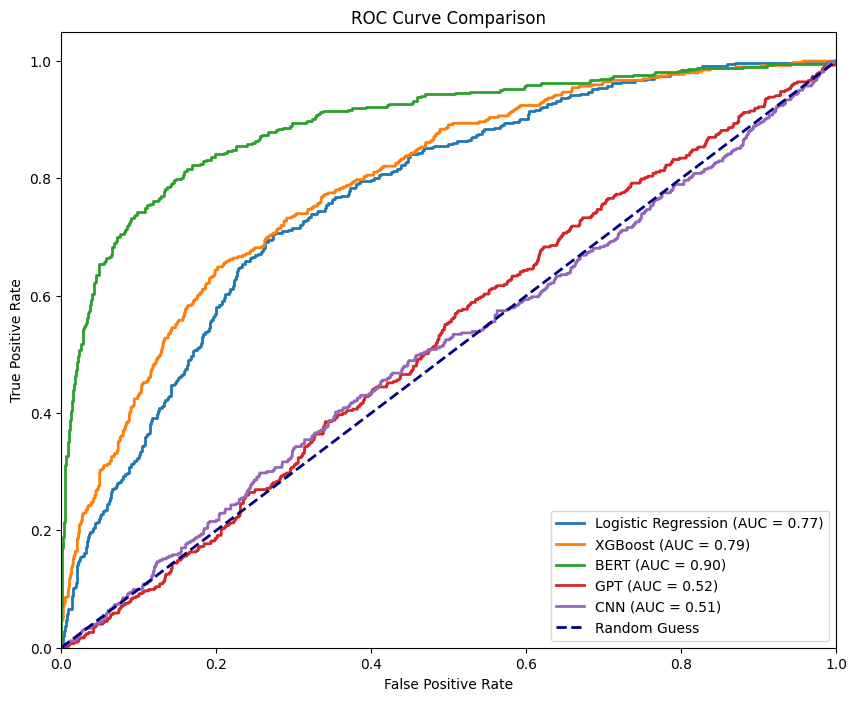

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch

# 假设以下模型和数据已经准备好：
# - 机器学习模型：best_clf_xgb, best_svm_rbf_model, clf_logit
# - 深度学习模型：model_bert, model_gpt, model_cnn
# - 数据：X_test_scaled, y_test（用于机器学习）和 test_dataloader（用于深度学习）

# 1. **ROC 曲线绘制**
def plot_roc_curve(classifier_name, y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

# 获取机器学习模型的预测概率
logreg_prob = clf_logit.predict_proba(X_test)[:, 1] # Logistic Regression
# svc_prob = best_svm_rbf_model.predict_proba(X_test_scaled)[:, 1]  # SVM with RBF Kernel
xgb_prob = best_clf_xgb.predict_proba(X_test)[:, 1]  # XGBoost

# 修改 get_dl_model_probabilities 函数，使用模型的设备
def get_dl_model_probabilities(model, dataloader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for input_ids, attention_mask, labels in dataloader:
            input_ids = input_ids.to(device)  # 使用指定设备
            attention_mask = attention_mask.to(device)  # 使用指定设备
            logits = model(input_ids, attention_mask)  # 获取 logits
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # 获取正类概率
            all_probs.extend(probs)
            all_labels.extend(labels.numpy())
    return np.array(all_probs), np.array(all_labels)

bert_prob, y_test_dl = get_dl_model_probabilities(model_bert, test_loader)
gpt_prob, _ = get_dl_model_probabilities(model_gpt, test_loader)
cnn_prob, _ = get_dl_model_probabilities(model_cnn, test_loader)

# 绘制 ROC 曲线
plt.figure(figsize=(10, 8))
classifiers = {
    "Logistic Regression": logreg_prob,
    # "SVM (RBF Kernel)": svc_prob,
    "XGBoost": xgb_prob,
    "BERT": bert_prob,
    "GPT": gpt_prob,
    "CNN": cnn_prob,
}

for name, prob in classifiers.items():
    # 判断是否为深度学习模型，使用不同的 y_true
    y_true = y_test if name in ["Logistic Regression", "SVM (RBF Kernel)", "XGBoost"] else y_test_dl
    plot_roc_curve(name, y_true, prob)

# 添加基准线和格式设置
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()


In [29]:
from statsmodels.stats.contingency_tables import cochrans_q, mcnemar
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import torch

# 构建预测结果
y_preds = {
    "Logistic Regression": (logreg_prob > 0.5).astype(int),
    # "SVM (RBF Kernel)": (svc_prob > 0.5).astype(int),
    "XGBoost": (xgb_prob > 0.5).astype(int),
    "BERT": (bert_prob > 0.5).astype(int),
    "GPT": (gpt_prob > 0.5).astype(int),
    "CNN": (cnn_prob > 0.5).astype(int),
}

# 统计检验
y_true_word2vec = np.array(y_test)  # 如果 y_test 是 pandas Series，转换为 NumPy 数组
y_true_raw_text = np.array(y_test_dl)

y_preds = {name: np.array(pred) for name, pred in y_preds.items()}  # 转换为 NumPy 数组


# 构造正确性矩阵
correct_matrix = np.array([
    [
        1 if (pred[i] == (y_true_word2vec[i] if name in ["Logistic Regression", "SVM (RBF Kernel)", "XGBoost"] else y_true_raw_text[i]))
        else 0
        for name, pred in y_preds.items()
    ]
    for i in range(len(y_true_word2vec))  # 确保 y_true_word2vec 和 y_true_raw_text 长度一致
])

# Cochran's Q Test
result = cochrans_q(correct_matrix)
stat = result.statistic  # 访问统计量
p_value = result.pvalue  # 访问 p-value

print(f"Cochran's Q Test Statistic: {stat}, p-value: {p_value}")

# McNemar 检验与 Bonferroni 校正
pairwise_p_values = []
model_names = list(y_preds.keys())

for model1, model2 in combinations(model_names, 2):
    pred1 = y_preds[model1]
    pred2 = y_preds[model2]
    b01 = np.sum((pred1 != y_true_word2vec) & (pred2 == y_true_word2vec))
    b10 = np.sum((pred1 == y_true_word2vec) & (pred2 != y_true_word2vec))
    result = mcnemar([[0, b01], [b10, 0]], exact=True if (b01 + b10) < 25 else False)
    pairwise_p_values.append((model1, model2, result.pvalue))

# Bonferroni 校正
_, corrected_p_values, _, _ = multipletests([p[2] for p in pairwise_p_values], method="bonferroni")
for (model1, model2, original_p), corrected_p in zip(pairwise_p_values, corrected_p_values):
    print(f"{model1} vs {model2}: Original p-value={original_p:.5f}, Corrected p-value={corrected_p:.5f}")

Cochran's Q Test Statistic: 417.5, p-value: 4.5996932745093295e-89
Logistic Regression vs XGBoost: Original p-value=0.00000, Corrected p-value=0.00000
Logistic Regression vs BERT: Original p-value=0.00000, Corrected p-value=0.00000
Logistic Regression vs GPT: Original p-value=0.00029, Corrected p-value=0.00292
Logistic Regression vs CNN: Original p-value=0.00000, Corrected p-value=0.00000
XGBoost vs BERT: Original p-value=0.00000, Corrected p-value=0.00000
XGBoost vs GPT: Original p-value=0.00000, Corrected p-value=0.00000
XGBoost vs CNN: Original p-value=0.00000, Corrected p-value=0.00000
BERT vs GPT: Original p-value=0.00000, Corrected p-value=0.00001
BERT vs CNN: Original p-value=0.00013, Corrected p-value=0.00132
GPT vs CNN: Original p-value=0.00000, Corrected p-value=0.00000


In [59]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# 提取 SHAP 值并映射到词级
def compute_word_shap(sentence, shap_values_row, w2v_model):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(word_vectors) == 0:
        return None
    word_shap = {}
    for word, vector in zip(words, word_vectors):
        word_shap[word] = np.dot(shap_values_row[:100], vector)  # 将 SHAP 分数分配给词
    return word_shap

# 构建词级 SHAP 贡献表
word_shap_contributions = []
for sentence, shap_row in zip(X_test_original, shap_values):
    word_shap = compute_word_shap(sentence, shap_row, w2v_model)
    if word_shap:
        word_shap_contributions.append(word_shap)

# 汇总词的贡献值
word_contributions = {}
for word_shap in word_shap_contributions:
    for word, value in word_shap.items():
        if word in word_contributions:
            word_contributions[word].append(value)
        else:
            word_contributions[word] = [value]

# 计算每个词的平均 SHAP 值
word_avg_contribution = {word: np.mean(values) for word, values in word_contributions.items()}

# 按贡献值排序
sorted_word_contributions = sorted(word_avg_contribution.items(), key=lambda x: x[1], reverse=True)

# 打印前 10 个词的贡献值
print("Top words by SHAP contribution:")
print(sorted_word_contributions[:20])


Top words by SHAP contribution:
[('Swimming', 0.1779556), ('cuz', 0.15959397), ('Exposure', 0.15544498), ('PalestineChron', 0.14309147), ("you'd", 0.14093317), ('revisits', 0.13896185), ('distributes', 0.13832255), ('Guard', 0.13485913), ('speeds', 0.1319818), ('NEW:', 0.12609622), ('3-4', 0.1257735), ('Talisay,', 0.12496481), ('Curfew', 0.123081), ('coronavirus', 0.122413695), ('2:00', 0.1218191), ('“You’ll', 0.121143214), ('ministr', 0.120478064), ('crippled', 0.12035331), ('island.', 0.120304264), ('Doyle,', 0.11982838)]


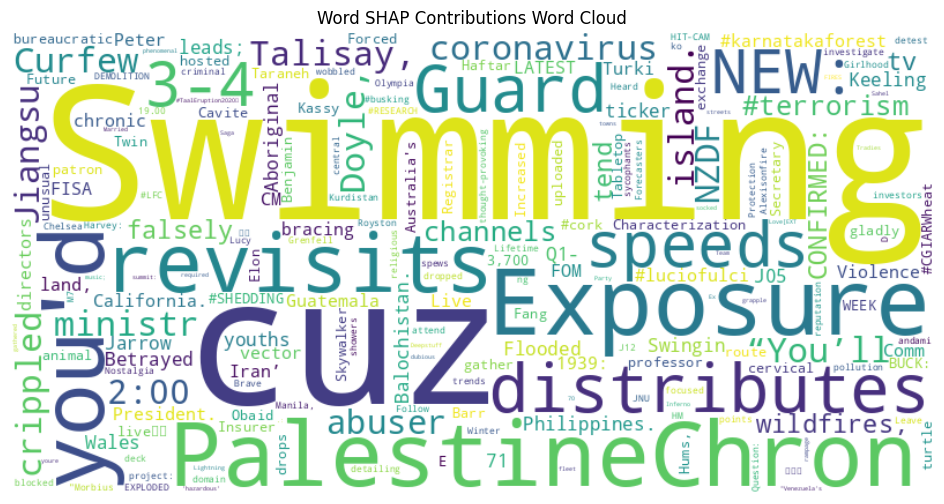

In [60]:
from wordcloud import WordCloud

# 绘制词云
def plot_wordcloud(word_contributions):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate_from_frequencies(word_contributions)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word SHAP Contributions Word Cloud")
    plt.show()

# 调用词云函数
plot_wordcloud(word_avg_contribution)


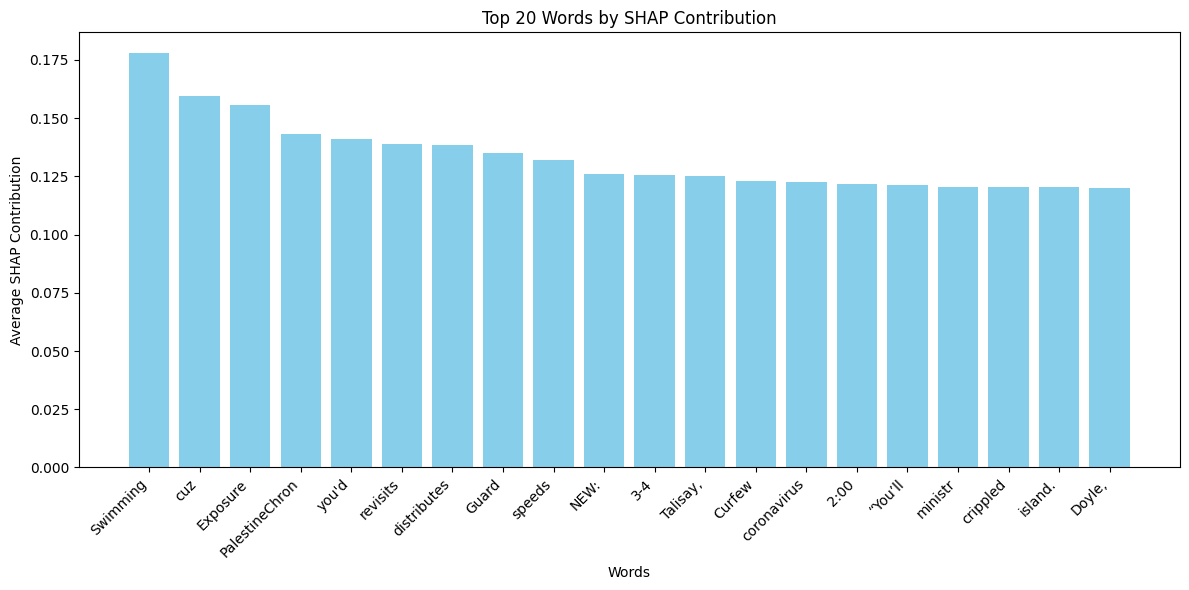

In [61]:
import matplotlib.pyplot as plt

# 绘制按贡献值排序的前 N 个词
def plot_top_words(word_contributions, top_n=20):
    # 排序并选择前 N 个词
    sorted_contributions = sorted(word_contributions.items(), key=lambda x: x[1], reverse=True)[:top_n]
    words, contributions = zip(*sorted_contributions)

    # 绘制柱状图
    plt.figure(figsize=(12, 6))
    plt.bar(words, contributions, color="skyblue")
    plt.xlabel("Words")
    plt.ylabel("Average SHAP Contribution")
    plt.title(f"Top {top_n} Words by SHAP Contribution")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# 调用绘图函数
plot_top_words(word_avg_contribution, top_n=20)


In [36]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def add_noise(X, noise_level=0.1):
    """在数据中添加随机噪声"""
    noisy_X = X + noise_level * np.random.normal(0, 1, X.shape)
    return np.clip(noisy_X, 0, 1)

for noise_level in [0.05, 0.1, 0.2]:
    X_test_noisy = add_noise(X_test)
    for name, model in zip(classifiers.keys(), [clf_logit, best_clf_xgb, model_bert, model_gpt, model_cnn]):
        if name in ["Logistic Regression", "Random Forest", "XGBoost"]:
            y_pred_proba_noisy = model.predict_proba(X_test_noisy)[:, 1]  # 获取正类概率
            y_pred_noisy = (y_pred_proba_noisy > 0.5).astype(int)  # 转为离散标签
        else:
            # 对深度学习模型处理 dataloader
            y_pred_proba_noisy, _ = get_dl_model_probabilities(model, test_loader)
            y_pred_noisy = (y_pred_proba_noisy > 0.5).astype(int)  # 转为离散标签

        # 确定使用的 y_true
        y_true = y_test if name in ["Logistic Regression", "Random Forest", "XGBoost"] else y_test_dl

        # 计算 Accuracy 和 F1 Score
        acc = accuracy_score(y_true, y_pred_noisy)
        f1 = f1_score(y_true, y_pred_noisy)
        print(f"Noise Level {noise_level}, Model {name}: Accuracy={acc:.5f}, F1 Score={f1:.5f}")


Noise Level 0.05, Model Logistic Regression: Accuracy=0.81486, F1 Score=0.09071
Noise Level 0.05, Model XGBoost: Accuracy=0.82586, F1 Score=0.00000
Noise Level 0.05, Model BERT: Accuracy=0.75726, F1 Score=0.10680
Noise Level 0.05, Model GPT: Accuracy=0.71856, F1 Score=0.16010
Noise Level 0.05, Model CNN: Accuracy=0.79024, F1 Score=0.05545
Noise Level 0.1, Model Logistic Regression: Accuracy=0.82366, F1 Score=0.11479
Noise Level 0.1, Model XGBoost: Accuracy=0.82586, F1 Score=0.00000
Noise Level 0.1, Model BERT: Accuracy=0.76869, F1 Score=0.14887
Noise Level 0.1, Model GPT: Accuracy=0.72296, F1 Score=0.17323
Noise Level 0.1, Model CNN: Accuracy=0.79024, F1 Score=0.05545
Noise Level 0.2, Model Logistic Regression: Accuracy=0.80739, F1 Score=0.06809
Noise Level 0.2, Model XGBoost: Accuracy=0.82586, F1 Score=0.00000
Noise Level 0.2, Model BERT: Accuracy=0.76165, F1 Score=0.12298
Noise Level 0.2, Model GPT: Accuracy=0.72823, F1 Score=0.18898
Noise Level 0.2, Model CNN: Accuracy=0.79376, F1 S

In [35]:
classifiers.keys()

dict_keys(['Logistic Regression', 'XGBoost', 'BERT', 'GPT', 'CNN'])